# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2025/26
 * Lecture by: Constantin Pape
 * Organizers: Anwai Archit, Sushmita Nair
 * Tutors: Azhar Akhmetova, Benjamin Eckhardt, Carolin Teuber, Luca Freckmann, Marei Freitag, Oleg Bakumenko, Sarah Muth
 * Due date: **Tuesday, Nov 25, before 10:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2` -> `Tutorial X` (where X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [JupyterHPC](https://jupyter.hpc.gwdg.de/), which offers convenient access to a GPU. We have provided access to all the dependencies that we need preinstalled ([here](https://docs.google.com/document/d/1frgBvU9ZRcR7PkMqOuK5eTj5RphZBmjz_i6OgA1DVwE/edit?usp=sharing) are the initial steps and step-by-step guide to get started with working on JupyterHPC).

In addition, another recommended solution would be using [Kaggle](https://www.kaggle.com/), which also offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on Kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os
import sys
import time
import importlib

In [2]:
project_path = Path(os.environ.get("PROJECT")).resolve()

## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you use JupyterHPC (recommended), the file with functions from exercise 1 is already uploaded to `$PROJECT/utils/setup.py`.

Hint:
To load a custom script from path you can use `importlib` module together with this code:
```python
spec = importlib.util.spec_from_file_location("module_name", module_path)
s = importlib.util.module_from_spec(spec) # we call it s for setup
spec.loader.exec_module(s)
```
and validate it for example by getting the device: `s.get_device()`.

Alternatively you can copy the file to your workspace using terminal `cp $PROJECT/utils/setup.py $HOME/your/notebook/location/` and import as usuall:

`import setup as s`


#### For Kaggle users
If you work with Kaggle you have to mount the drive first and create a path to your python module or download the file from drive.
Create a file named `setup.py` and copy all the necessary functions to it, e.g. dataset preparation and training. 

Alternativelly you can download this file to your workspace from drive and import it on this notebook. 
File URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

Hint:
For download you can use the package `gdown`

```python
!conda install -y gdown
!gdown <file_id>
```

where, `file_id` is "1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk"

Then, setup.py should be added to your workspace and you can import it as usual module `import setup as s` 

In [3]:
%cp $PROJECT/utils/setup.py ./

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation CIFAR10 datasets along with their dataloaders.

In [4]:
# TODO: Define device
import setup as s
device = s.get_device()

cuda available: True; cudnn available: True; num devices: 1
Using device Tesla V100-PCIE-32GB


In [5]:
data_dir = Path(project_path, "data", "Ex1")
batch_size = 512

# TODO: Grab data, generate split and initialize data loaders
trainset, testset = s.grab_data(data_dir)
trainset, valset = s.generate_train_val_data_split(trainset)
trainloader, valloader, testloader = s.init_data_loaders(trainset, valset, testset)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [6]:
# TODO: Define loss function
loss_fn = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

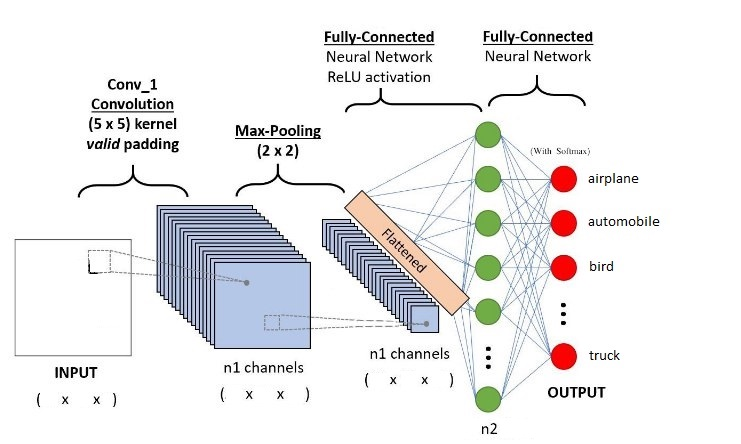

#### **Questions**

- What are the input dimensions?
    - A: 32x32x3, as the images in CIFAR-10 are
- What are the dimensions of the feature maps?
    - A: 28x28 after the convolution with the 5x5 filters, because they shrink by k-1 pixels.  
- What are the dimensions after pooling?
    - A: 14x14 
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
    - A: 14x14x32(number of filters) = 6272 
- What is the number of parameters for conv_1?
    - A: Filters x Kernel Size x Channels= 32x5x5x3 = 2400

**Your answers here**

In [7]:
# TODO: Define model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #empty layers
        layers = []
        
        layers.append(nn.Conv2d(3,32,5))
        
        layers.append(nn.MaxPool2d(2))

        layers.append(nn.ReLU())

        layers.append(nn.Flatten())
        layers.append(nn.Linear(32*14*14, 512))

        layers.append(nn.ReLU())

        layers.append(nn.Linear(512, 10))

        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        x_preds = self.layers(x)
        return x_preds
    

#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

In [8]:
# TODO: Train and plot
model = CNN()
model.to(device)

num_epochs = 10
lr=0.001
optimizer = optim.Adam(model.parameters(), lr)

trainloss, valloss, trainacc, valacc, confmat = s.run_training(model, optimizer, loss_fn, device, 
                                                      num_epochs, trainloader, valloader)

Finished training after 236 seconds.


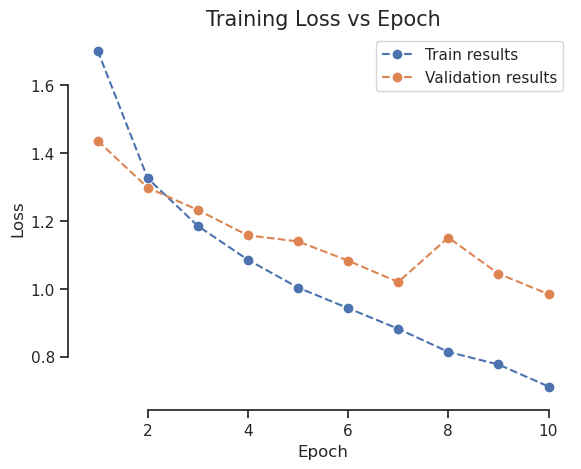

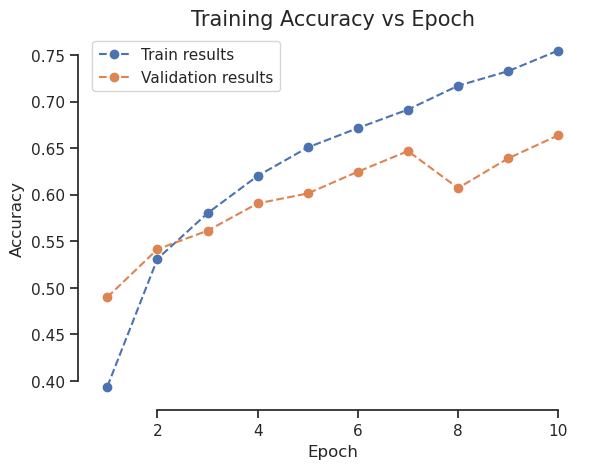

In [9]:
s.plot(
    title = "Training Loss vs Epoch",
    label = "Loss",
    train_results = trainloss,
    val_results = valloss
)
s.plot(
    title = "Training Accuracy vs Epoch",
    label = "Accuracy",
    train_results = trainacc,
    val_results = valacc
)


#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**
We can see that the loss started off lower in the first epoch in our CNN. The total loss of the training results was also lower in our 10th epoch than in the 100th of the MLP

The accuracy was also better in ours in the first epoch, and better than the MLP in the final one.

**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

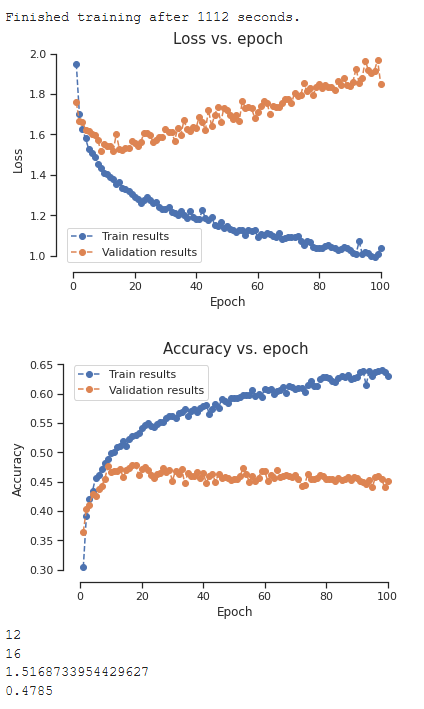

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

In [10]:
# TODO: Train and plot
num_epochs = 60
trainloss, valloss, trainacc, valacc, confmat = s.run_training(model, optimizer, loss_fn, device, 
                                                      num_epochs, trainloader, valloader)

Finished training after 1270 seconds.


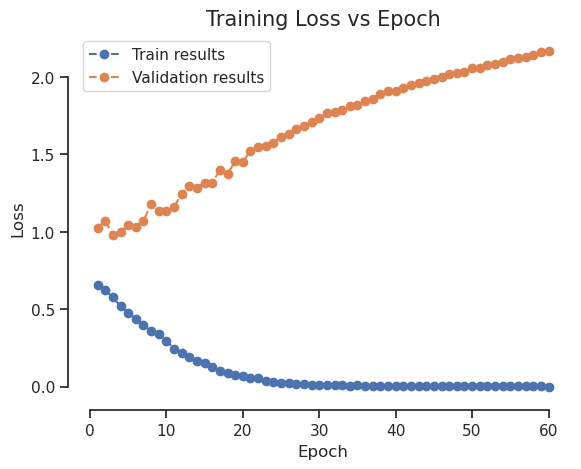

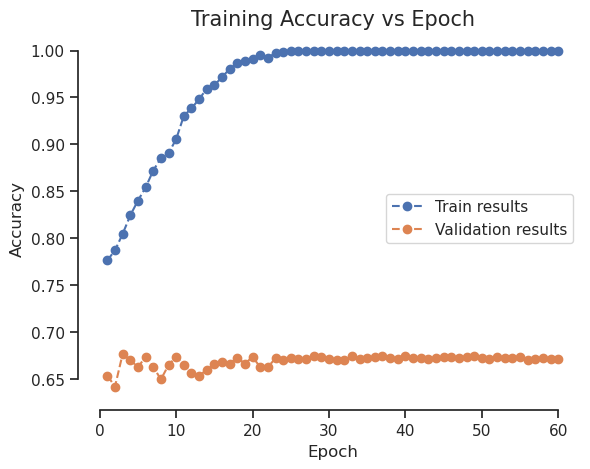

In [11]:
s.plot(
    title = "Training Loss vs Epoch",
    label = "Loss",
    train_results = trainloss,
    val_results = valloss
)
s.plot(
    title = "Training Accuracy vs Epoch",
    label = "Accuracy",
    train_results = trainacc,
    val_results = valacc
)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

The model obviously overfits, as you can see with the accuracy reaching almost 1 at around epoch 20 on the training accuracy

We could improve it by adding more 

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture using the following information:



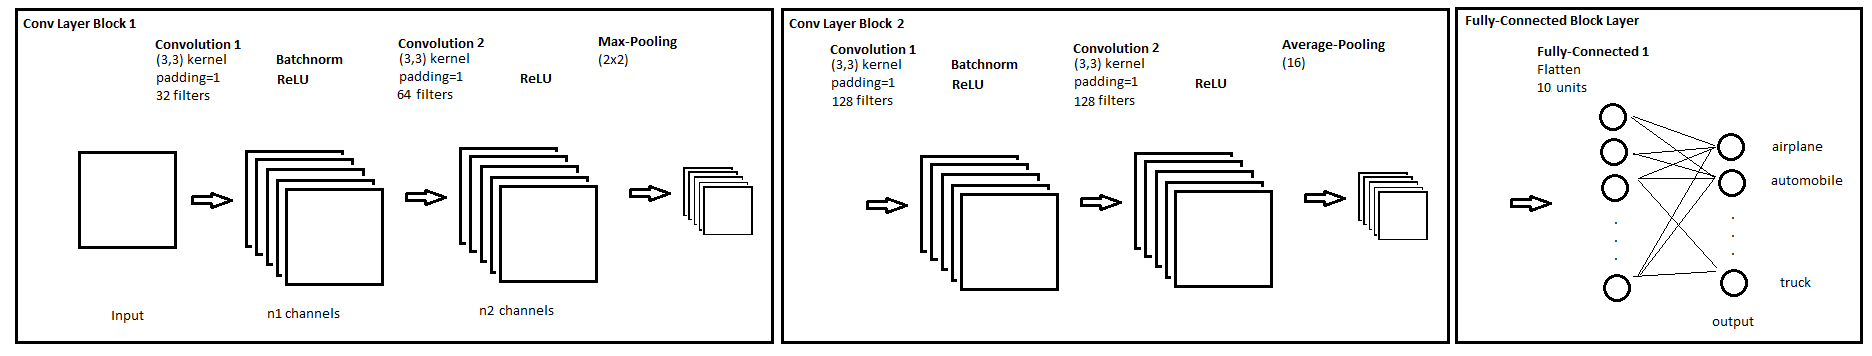

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

1. Adding padding to a picture, means adjusting the size of a picture before applying convolution with a kernel to increase the size of the output and thus the reflecting features of the feature maps. There exists Zero Padding, Reflective Padding, Valid padding, same padding, full padding.
2. We increase the size of the input by 1, e.g.: for 32x32 we get 33x33
3. ((32-3+2*1)/1) + 1 = 31
4. ((31-3+2*1)/1) + 1 = 31
5. 1+((3-1)+(3-1)) = 5
6. The average pooling with kernel size 16 x 16 after the 4th layer reduces the spatial dimension to 1 x 1. This results in only depth, so the number of channels. The last convolutional layer has 128 filters. So the depth of the feature map is 128. For the fully-conected layer, the feature map is flattened so: 1 x 1 x 128
7. 3*3*3*32 + 32 = 864 + 32 = 896, Batch Normalization = 32 + 32 = 64
3 * 3 * 32 * 64 + 64 = 18432 + 64 = 18496
Total number of parameters of Conv Layer block 1 is: 896 + 64 + 18496 = 19456

In [12]:
# TODO: Define model 2

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define layers
        layers = []
        # Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
        layers.append(nn.Conv2d(3, 32, 3, padding=1)) # M = N + 2p - k +1 = 32 + 2 - 3 + 1 = 32

        # Batchnorm and ReLU layers
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        
        # Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
        layers.append(nn.Conv2d(32, 64, 3, padding=1)) # M = N + 2p - k +1 = 32 + 2 - 3 + 1 = 32
        
        # ReLU Activation layer
        layers.append(nn.ReLU())
        
        # Max pooling with kernel size of 2*2
        layers.append(nn.MaxPool2d(2)) # N = 32/2 = 16
        
        # Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
        layers.append(nn.Conv2d(64, 128, 3, padding=1)) # M = N + 2p - k +1 = 16 + 2 - 3 + 1 = 16
        
        # Batchnorm and ReLU layers
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.ReLU())
        
        # Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
        layers.append(nn.Conv2d(128, 128, 3, padding=1)) # M = N + 2p - k +1 = 16 + 2 - 3 + 1 = 16
        
        # ReLU Activation layer
        layers.append(nn.ReLU())
        
        # Average pooling with kernel size 16*16
        layers.append(nn.AvgPool2d(16)) # M = 16 / 16 = 1
        
        # Fully connected layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(128 * 1 * 1, 10))

        # Create sequential model
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x_predictions = self.layers(x)

        # Return the predicted output
        return x_predictions

#### **TODO** 

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [17]:
# TODO: Train and plot
model2 = CNN2()
model2.to(device)

num_epochs = 30
lr = 0.01
optimizer = optim.Adam(model2.parameters(), lr)
trainloss, valloss, trainacc, valacc, confmat = s.run_training(model2, optimizer, loss_fn, device, num_epochs, trainloader, valloader, verbose=True)

torch.save(model2.state_dict(), './model2.pth')

KeyboardInterrupt: 

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

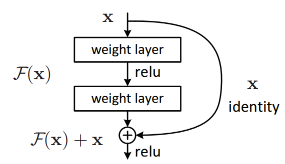

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

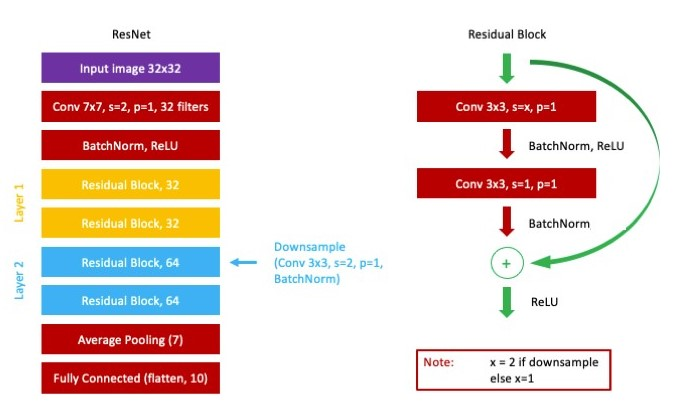

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [18]:
# TODO: Write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = False, disable_residual = False):
        super().__init__()
        
        # Define layers
        layers = []

        # Conv 1
        self.stride = 2 if downsample else 1
            
        layers.append(nn.Conv2d(in_channels, out_channels, 3, stride=self.stride, padding=1))

        
        # Batchnorm and ReLU layers
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())

        # Conv 2
        layers.append(nn.Conv2d(out_channels, out_channels, 3, stride = 1, padding=1))

        # Batchnorm
        layers.append(nn.BatchNorm2d(out_channels))
        
        # Create sequential model
        self.layers = nn.Sequential(*layers)
        
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=(3, 3), 
                    stride = 2,
                    padding=1, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
            
        self.disable_residual = disable_residual
        
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        
        identity = self.downsample(x) if self.downsample else x
        
        x_predictions = self.layers(x)
        # Add residual ReLU
        if not self.disable_residual:
            x_predictions = x_predictions + identity
            
        x_predictions = torch.relu(x_predictions)

        # Return the predicted output
        return x_predictions

In [19]:
# TODO: Write a class ResNet(nn.Module) where you define the model
# TODO: Write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
    def __init__(self, disable_residual = False):
        super().__init__()
        
        # Define layers
        layers = []

        # Conv 7x7, s=2, p=1, 32 filters
        layers.append(nn.Conv2d(3,32,7, stride=2, padding=1)) # M = (32+2+7)/2 + 1 = 14 
        
        # Batchnorm and ReLU layers
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())

        # Layer 1
        layers.append(ResidualBlock(32,32, disable_residual=disable_residual))
        layers.append(ResidualBlock(32,32, disable_residual=disable_residual))
        
        # Layer 2
        layers.append(ResidualBlock(32,64,downsample=True, disable_residual=disable_residual))
        layers.append(ResidualBlock(64,64, disable_residual=disable_residual))
        
        # Average pooling with kernel size 7*7
        layers.append(nn.AvgPool2d(7)) # M =  / 7 = 1
        
        # Fully connected layer
        layers.append(nn.Flatten())
        layers.append(nn.Linear(64, 10))
        
        # Create sequential model
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        x_predictions = self.layers(x)

        # Return the predicted output
        return x_predictions

In [22]:
# TODO: Train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.
resnet_model = ResNet()
resnet_model.to(device)

num_epochs = 100
lr = 0.01
optimizer = optim.Adam(resnet_model.parameters(), lr)
early_stopper = s.EarlyStopper(patience = 10)
trainloss, valloss, trainacc, valacc, confmat = s.run_training(resnet_model, optimizer, loss_fn, device, num_epochs, trainloader, valloader, early_stopper=early_stopper,verbose=True)

torch.save(resnet_model.state_dict(), './resnet_model.pth')

early stopping
Finished training after 720 seconds.


/mnt/vast-standard/home/lennart.hahner/u23584/jupyterhub-gwdg/setup.py:447: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.path))


In [ ]:
# TODO: Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.
title = "Training Accuracy vs Epoch"
plot(
    title = title,
    label = "Accuracy",
    train_results = trainacc,
    val_results = valacc)

title = "Training Loss vs Epoch"
plot(
    title = title,
    label = "Loss",
    train_results = trainloss,
    val_results = valloss)

#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
- In deeper networks, how would you expect residual blocks to influence training time? why?
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use `StepLR` (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.1

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.9

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

In [ ]:
# TODO: Train and plot with step size 15, gamma 0.1, 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

## 7. LR-Scheduling _(Optional)_

#### TODO _(Optional)_
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

In [ ]:
# TODO (Optional): Train and plot with different schedulers

**Your answers here**